In [1]:
import pandas as pd
import numpy as np
import pathlib as pl
import sklearn
import pathlib as pl

In [2]:
# dictionarypath = '../dataset/dictionary/Loughran-McDonald_MasterDictionary_1993-2021.csv'
# wds_dict = pd.read_csv(dictionarypath)
# positive_wds = [row['Word'].lower() for i, row in wds_dict.iterrows() if row['Positive']!=0]
# negative_wds = [row['Word'].lower() for i, row in wds_dict.iterrows() if row['Negative']!=0]

dictionarypath = '../dataset/dictionary/LM-SA-2020.csv'
wds_dict = pd.read_csv(dictionarypath)
positive_wds = [row['word'] for i, row in wds_dict.iterrows() if row['sentiment']=='Positive']
negative_wds = [row['word'] for i, row in wds_dict.iterrows() if row['sentiment']=='Negative']

In [3]:
# path = '../dataset/finRep/FinancialPhraseBank/all-data.csv'
# df = pd.read_csv(path, encoding = "ISO-8859-1", names = ['sentiment', 'sentence'])
# # print(df[:10])
# path = '../dataset/finRep/FiQA/fiqa_extended.csv'

path = '../dev/web_scrapper/sentfin_extended_final.csv'
df = pd.read_csv(path, encoding = "ISO-8859-1")

# df['sentiment_score'] = np.where((df['sentiment_score'] < 0.35 ) & (df['sentiment_score'] > -0.35), 0, df['sentiment_score'])
# df['sentiment_score'] = np.where((df['sentiment_score'] >= 0.35 ), 1, df['sentiment_score'])
# df['sentiment_score'] = np.where((df['sentiment_score'] <= -0.35 ), -1, df['sentiment_score'])
# df['sentiment_score'] = df['sentiment_score'].astype(int)
df

,Title,Decisions,links,source,title,body
0,The empire strikes back: Why gold will matter ...,neutral,https://m.economictimes.com/markets/commoditie...,m.economictimes.com,The empire strikes back: Why gold will matter ...,MUMBAI: The year 2013 was a forgettable one fo...
1,Top brokers recommend 'subscribe' to Syngene I...,neutral,https://m.economictimes.com/markets/ipos/fpos/...,m.economictimes.com,Top brokers recommend 'subscribe' to Syngene I...,NEW DELHI: Brokerages are advising long-term i...
2,"Ujjivan Financial Rs 1,500 crore IPO to hit D-...",neutral,https://economictimes.indiatimes.com/markets/i...,economictimes.indiatimes.com,"Ujjivan Financial's Rs 1,500 crore IPO to hit ...",MUMBAI: Ujjivan Financial will be the first mi...
3,UTI AMC shortlists 3 names for Chairman and MD...,neutral,https://m.economictimes.com/uti-amc-shortlists...,m.economictimes.com,UTI AMC shortlists 3 names for Chairman and MD...,"NEW DELHI: UTI AMC, India's oldest asset manag..."
4,"UTI MF appoints Kaeley as group president, sal...",neutral,https://m.economictimes.com/uti-mf-appoints-ka...,m.economictimes.com,"UTI MF appoints Kaeley as group president, sal...",MUMBAI: UTI Mutual Fund has appointed Suraj Ka...
...,...,...,...,...,...,...
1914,"Sensex rangebound, trades below 26000; top 20 ...","{""Sensex"": ""neutral""}",https://m.economictimes.com/sensex-rangebound-...,m.economictimes.com,"Sensex rangebound, trades below 26000; top 20 ...",NEW DELHI: The S&P BSE Sensex was trading in a...
1915,Sensex takes a breather; top ten stocks in focus,"{""Sensex"": ""neutral""}",https://m.economictimes.com/markets/stocks/new...,m.economictimes.com,Sensex takes a breather; top ten stocks in focus,NEW DELHI: The S&P BSE Sensex was trading in a...
1916,Sentimental impact coal pricing is inevitable:...,"{""coal"": ""neutral""}",https://m.economictimes.com/sentimental-impact...,m.economictimes.com,Sentimental impact coal pricing is inevitable:...,"In a chat with ET Now, P Phani Sekhar, Fund Ma..."
1917,Servalakshmi Paper Ltd receives SEBI approval ...,"{""Servalakshmi Paper Ltd"": ""neutral"", ""SEBI"": ...",https://m.economictimes.com/markets/ipos/fpos/...,m.economictimes.com,Servalakshmi Paper Ltd receives SEBI approval ...,MUMBAI: Servalakshmi Paper Ltd on Thursday sai...


<AxesSubplot:>

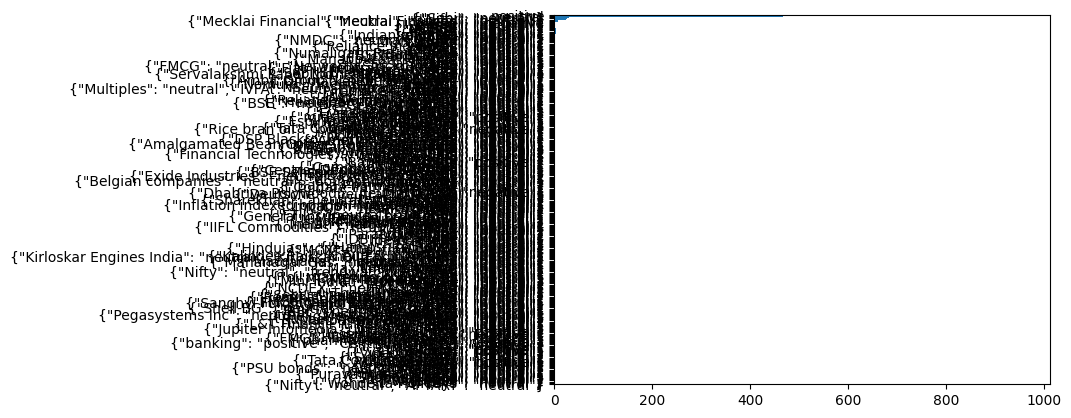

In [4]:
df.Decisions.value_counts().sort_values().plot(kind = 'barh')
# df.sentiment_score.value_counts().sort_values()

In [5]:
# to install keybert
# !pip install nltk
# !pip install keybert
# !pip install sentence-transformers
# !pip install git+https://github.com/LIAAD/yake
### To show the execution times
# !pip install ipython-autotime
# %load_ext autotime

In [6]:
import re

sample = df.sample(1).iloc[0]
title = sample['Title']
text = sample['body']
sentiment = sample['Decisions']
text = re.sub(r'[^A-Za-z0-9 .,;?!]+', ' ', text)
text = re.sub(' +', ' ', text)
print('Title: ' ,title)
print(text)
print('\nSentiment: ', sentiment)

Title:  SCI soars 8 pc in early trade on BSE
MUMBAI Shipping Corporation of India surged by over 8 per cent in early trade on the BSE today, a day after the government allowed the Navratna PSU to issue fresh equity to the tune of 10 per cent of its paid up capital. Buoyed by the development, shares of the company zoomed up 8.12 per cent to hit a one month high of Rs 181.75 in early trade on the Bombay Stock Exchange. Yesterday, the Cabinet Committee on Economic Affairs had given approval for the sale of a 10 per cent stake in Shipping Corporation of India and allowed the company to issue fresh equity to the tune of 10 per cent of the paid up capital. The government said disinvestment in SCI is expected to fetch nearly Rs 1,300 crore. Shares of SCI witnessed a similar movement on the National Stock Exchange and soared by as much as 16.48 per cent to Rs 195.70 in morning trade. On the volume front, about 45 lakh shares of the company were traded on the bourses in the morning session. Mea

In [7]:
def normalize_keyword_list(keyword_list):
    keys = []
    for keyword in keyword_list:
        keys.append(keyword[0])
    return keys

Rake

In [8]:
from rake_nltk import Rake
rake_nltk_var = Rake()

rake_nltk_var.extract_keywords_from_text(text)
rake_keywords = rake_nltk_var.get_ranked_phrases()
print(rake_keywords)

['30 share sensex index', 'fetch nearly rs 1', '10 per cent stake', '10 per cent', '10 per cent', '48 per cent', '12 per cent', 'one month high', 'national stock exchange', 'issue fresh equity', 'issue fresh equity', 'bombay stock exchange', 'government said disinvestment', '8 per cent', 'mumbai shipping corporation', '45 lakh shares', 'early trade today', 'shipping corporation', 'rs 195', 'rs 181', 'early trade', 'early trade', 'morning trade', 'volume front', 'similar movement', 'previous close', 'positive terrain', 'navratna psu', 'morning session', 'government allowed', 'given approval', 'economic affairs', 'cabinet committee', 'bse today', '96 points', '300 crore', 'sci witnessed', 'india surged', 'company zoomed', '8', 'shares', 'shares', 'sci', 'india', 'bse', 'allowed', 'company', 'company', 'yesterday', 'tune', 'tune', 'traded', 'soared', 'sale', 'rising', 'paid', 'paid', 'much', 'meanwhile', 'hit', 'expected', 'development', 'day', 'capital', 'capital', 'buoyed', 'bourses', '

In [9]:
# !pip3 install keyphrase-vectorizers

In [10]:
# Import them
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
from keyphrase_vectorizers import KeyphraseCountVectorizer

sent_trans = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
keyBERT_model = KeyBERT(model = sent_trans)

In [11]:
def extract_terms(document, vectorizer, 
                  top_N=7, model=keyBERT_model, diversity_threshold = 0.7):

  keywords = model.extract_keywords(document, stop_words='english', 
                                    vectorizer=vectorizer,
                                    use_mmr=True, 
                                    diversity = diversity_threshold,
                                    top_n = top_N
                                    )
  
  return sorted(keywords, key=lambda tup:(-tup[1], tup[0]))

In [12]:
# print(f'Text: {text}.\nLength: {len(text.split())}')
keybert_keywords = extract_terms(text, vectorizer=KeyphraseCountVectorizer())
keybert_keywords = normalize_keyword_list(keybert_keywords)

print(keybert_keywords)

['bombay stock exchange', 'sci', 'navratna psu', 'cabinet committee', 'day', 'per cent', 'volume front']


In [13]:
import yake
kw_extractor = yake.KeywordExtractor()
yake_keywords = kw_extractor.extract_keywords(text)
yake_keywords = normalize_keyword_list(yake_keywords)

print(yake_keywords)


# print("SECOND FORM:")
# language = "en"
# max_ngram_size = 3
# deduplication_threshold = 0.9
# deduplication_algo = 'seqm'
# windowSize = 1
# numOfKeywords = 20

# custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
# keywords = custom_kw_extractor.extract_keywords(text)

# for kw in keywords:
#     print(kw)

['MUMBAI Shipping Corporation', 'Navratna PSU', 'MUMBAI Shipping', 'issue fresh equity', 'Bombay Stock Exchange', 'Shipping Corporation', 'Corporation of India', 'PSU to issue', 'early trade', 'allowed the Navratna', 'National Stock Exchange', 'early trade today', 'India surged', 'Stock Exchange', 'cent', 'paid up capital', 'issue fresh', 'fresh equity', 'Bombay Stock', 'MUMBAI']


In [14]:
# !pip3 install pke-tool
# !pip3 install git+https://github.com/boudinfl/pke.git


Keyphrase Extraction using TopicalPageRank

In [15]:
import pke

# initialize keyphrase extraction model, here TopicRank
extractor = pke.unsupervised.TopicalPageRank()

# load the content of the document, here document is expected to be a simple 
# test string and preprocessing is carried out using spacy
extractor.load_document(input=text, language='en')

# keyphrase candidate selection, in the case of TopicRank: sequences of nouns
# and adjectives (i.e. `(Noun|Adj)*`)
extractor.candidate_selection()

# candidate weighting, in the case of TopicRank: using a random walk algorithm
extractor.candidate_weighting()

# N-best selection, keyphrases contains the 10 highest scored candidates as
# (keyphrase, score) tuples
tpr_keyphrases = extractor.get_n_best(n=10)
tpr_keyphrases = normalize_keyword_list(tpr_keyphrases)
print(tpr_keyphrases)

['early trade today', 'per cent stake', 'early trade', 'per cent', 'bombay stock exchange', 'national stock exchange', 'morning trade', 'cent', 'bse today', 'lakh shares']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)


In [16]:
Keywords = {}
Keywords["rake"] = rake_keywords
Keywords["keybert"] = keybert_keywords
Keywords["yake"] = yake_keywords
Keywords["tpr"] = tpr_keyphrases

print("Rake: %s" % Keywords["rake"]) 
print("Keybert: %s" % Keywords["keybert"]) 
print("Yake: %s" % Keywords["yake"])
print("Keyphrase: %s" % Keywords["tpr"])

Rake: ['30 share sensex index', 'fetch nearly rs 1', '10 per cent stake', '10 per cent', '10 per cent', '48 per cent', '12 per cent', 'one month high', 'national stock exchange', 'issue fresh equity', 'issue fresh equity', 'bombay stock exchange', 'government said disinvestment', '8 per cent', 'mumbai shipping corporation', '45 lakh shares', 'early trade today', 'shipping corporation', 'rs 195', 'rs 181', 'early trade', 'early trade', 'morning trade', 'volume front', 'similar movement', 'previous close', 'positive terrain', 'navratna psu', 'morning session', 'government allowed', 'given approval', 'economic affairs', 'cabinet committee', 'bse today', '96 points', '300 crore', 'sci witnessed', 'india surged', 'company zoomed', '8', 'shares', 'shares', 'sci', 'india', 'bse', 'allowed', 'company', 'company', 'yesterday', 'tune', 'tune', 'traded', 'soared', 'sale', 'rising', 'paid', 'paid', 'much', 'meanwhile', 'hit', 'expected', 'development', 'day', 'capital', 'capital', 'buoyed', 'bours

NLTK-VADER

In [17]:
print(keybert_keywords)

['bombay stock exchange', 'sci', 'navratna psu', 'cabinet committee', 'day', 'per cent', 'volume front']


In [18]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def vader(keywords):
    result = []
    for sentence in keywords:
        if (sid.polarity_scores(sentence)['compound']) >= 0.5:
            result.append(tuple((sentence, 1)))
        elif (sid.polarity_scores(sentence)['compound']) <= -0.5:
            result.append(tuple((sentence, -1)))
        else:
            result.append(tuple((sentence, 0)))
    return result

result = vader(keybert_keywords) 
print(result)            

[('bombay stock exchange', 0), ('sci', 0), ('navratna psu', 0), ('cabinet committee', 0), ('day', 0), ('per cent', 0), ('volume front', 0)]


Using TextBlob

In [19]:
from textblob import TextBlob

def textblob(keywords):
    result = []
    for sentence in keybert_keywords:
        testimonial = TextBlob(sentence)
        if testimonial.sentiment.polarity >= 0.5:
            result.append(tuple((sentence, 1)))
        elif testimonial.sentiment.polarity <= -0.5:
            result.append(tuple((sentence, -1)))
        else:
            result.append(tuple((sentence, 0)))
    return result

result = textblob(keybert_keywords)
print(result)


[('bombay stock exchange', 0), ('sci', 0), ('navratna psu', 0), ('cabinet committee', 0), ('day', 0), ('per cent', 0), ('volume front', 0)]


Using dictionary

In [20]:
def compare_words(keyword_list):
    result = []
    for sentence in keyword_list:
        words = sentence.split()
        score = 0
        for word in words:
            if word in positive_wds:
                score = score + 1
            elif word in negative_wds:
                score = score - 1
                
        if score > 0:
            score = 1
            result.append(tuple((sentence, score)))
        elif score < 0:
            score = -1
            result.append(tuple((sentence, score)))
        else:
            result.append(vader([sentence])[0])

    return result

In [21]:
keybert_sen = compare_words(keybert_keywords) #keybert

print(keybert_sen)

[('bombay stock exchange', 0), ('sci', 0), ('navratna psu', 0), ('cabinet committee', 0), ('day', 0), ('per cent', 0), ('volume front', 0)]


In [22]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [23]:
#! deprecated
# import spacy
# nlp = spacy.load('en_core_web_sm')
# FinalKeys = []  #FALTA AGREGAR EL 4TO KEYWORD EXTRACTOR!
# for keybert in Keywords["keybert"]:
#     word1 = nlp(keybert)
#     for rake in Keywords["rake"]:
#         word2 = nlp(rake)
#         for yake in Keywords["yake"]:
#             word3 = nlp(yake)
#             if word3.similarity(word1) > 0.7 and (not(keybert in FinalKeys)):
#                 FinalKeys.append(keybert)
#             if word3.similarity(word2) > 0.7 and not(rake in FinalKeys):
#                 FinalKeys.append(rake)
#             if word2.similarity(word1) > 0.7 and not(keybert in FinalKeys):
#                 FinalKeys.append(keybert)



# print(FinalKeys)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_

['bombay stock exchange', 'national stock exchange', 'issue fresh equity', 'mumbai shipping corporation', 'early trade today', 'shipping corporation', 'early trade', 'similar movement', 'cabinet committee', 'sci witnessed', 'india surged', 'company', 'sale', 'capital', 'sci', 'navratna psu', 'day', 'per cent', 'volume front']


In [34]:
import spacy
def keywords_extractor(list1,list2,FinalKeys):
    nlp = spacy.load('en_core_web_sm')
    for words in list1:
        word1 = nlp(words)
        for words2 in list2:
            word2 = nlp(words2)
            if word2.similarity(word1)>0.7 and (not(words in FinalKeys)):
                FinalKeys.append(words)
                # print("word: ",words)



In [35]:
FinalKeys = list()
keywords_extractor(Keywords["keybert"],Keywords["rake"],FinalKeys)
keywords_extractor(Keywords["yake"],Keywords["rake"],FinalKeys)
keywords_extractor(Keywords["keybert"],Keywords["tpr"],FinalKeys)
print(FinalKeys)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  


['bombay stock exchange', 'sci', 'navratna psu', 'cabinet committee', 'day', 'per cent', 'volume front', 'MUMBAI Shipping Corporation', 'issue fresh equity', 'Bombay Stock Exchange', 'Shipping Corporation', 'early trade', 'National Stock Exchange', 'early trade today', 'India surged', 'Stock Exchange', 'cent', 'fresh equity', 'Bombay Stock']


In [24]:
keys_sent = compare_words(FinalKeys) #keybert

print(keys_sent)

[('bombay stock exchange', 0), ('national stock exchange', 0), ('issue fresh equity', -1), ('mumbai shipping corporation', 0), ('early trade today', 0), ('shipping corporation', 0), ('early trade', 0), ('similar movement', 0), ('cabinet committee', 0), ('sci witnessed', 0), ('india surged', 0), ('company', 0), ('sale', 0), ('capital', 0), ('sci', 0), ('navratna psu', 0), ('day', 0), ('per cent', 0), ('volume front', 0)]


PREPROCESSING